### Predicting the amount of accidents happening in distric 11

In [ ]:
import os
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='data_cleaner')

In [2]:
sqlContext = SQLContext(sc)

In [3]:
from datetime import datetime
import pyspark.sql.functions as F #avoid conflicts with regular python functions
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [7]:
df = sqlContext.read.csv("/datasets/crashes_d11.csv", header='true')

In [8]:
df

DataFrame[_c0: string, RD_NO: string, CRASH_DATE_EST_I: string, CRASH_DATE: string, POSTED_SPEED_LIMIT: string, TRAFFIC_CONTROL_DEVICE: string, DEVICE_CONDITION: string, WEATHER_CONDITION: string, LIGHTING_CONDITION: string, FIRST_CRASH_TYPE: string, TRAFFICWAY_TYPE: string, LANE_CNT: string, ALIGNMENT: string, ROADWAY_SURFACE_COND: string, ROAD_DEFECT: string, REPORT_TYPE: string, CRASH_TYPE: string, INTERSECTION_RELATED_I: string, NOT_RIGHT_OF_WAY_I: string, HIT_AND_RUN_I: string, DAMAGE: string, DATE_POLICE_NOTIFIED: string, PRIM_CONTRIBUTORY_CAUSE: string, SEC_CONTRIBUTORY_CAUSE: string, STREET_NO: string, STREET_DIRECTION: string, STREET_NAME: string, BEAT_OF_OCCURRENCE: string, PHOTOS_TAKEN_I: string, STATEMENTS_TAKEN_I: string, DOORING_I: string, WORK_ZONE_I: string, WORK_ZONE_TYPE: string, WORKERS_PRESENT_I: string, NUM_UNITS: string, MOST_SEVERE_INJURY: string, INJURIES_TOTAL: string, INJURIES_FATAL: string, INJURIES_INCAPACITATING: string, INJURIES_NON_INCAPACITATING: string,

In [9]:
dfDay = (df
       .withColumn('Days', F.to_date("CRASH_DATE", 'MM/dd/yyyy hh:mm:ss a'))
      )

In [10]:
dfDay.select("Days").show(5)

+----------+
|      Days|
+----------+
|2019-09-01|
|2019-09-04|
|2019-09-06|
|2019-12-23|
|2019-12-26|
+----------+
only showing top 5 rows



In [11]:
pd_df = dfDay.groupBy("Days").count().toPandas().sort_values(by = "Days").reset_index(drop=True)

In [12]:
pd_df

,Days,count
0,2014-02-24,1
1,2015-05-20,1
2,2015-05-25,1
3,2015-07-04,1
4,2015-07-25,1
...,...,...
1625,2020-02-01,8
1626,2020-02-02,5
1627,2020-02-03,11
1628,2020-02-04,15


In [13]:
pd_df["Days"] = pd.DatetimeIndex(pd_df["Days"])
pd_df = pd_df.rename(columns={'Days': 'ds', 'count': 'y'})

In [14]:
pd_df

,ds,y
0,2014-02-24,1
1,2015-05-20,1
2,2015-05-25,1
3,2015-07-04,1
4,2015-07-25,1
...,...,...
1625,2020-02-01,8
1626,2020-02-02,5
1627,2020-02-03,11
1628,2020-02-04,15


In [15]:
m = Prophet(mcmc_samples=300)
m.fit(pd_df[:-60])
future = m.make_future_dataframe(
    periods=60,
    freq='d',
    include_history=True
)
fcst = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/dat500/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [16]:
forecasted_data = {'predicted': fcst.yhat[-60:].apply(lambda x: int(x)), 'true': pd_df.y[-60:]}
df_pred = pd.DataFrame(data=forecasted_data)
df_pred.head(15)

,predicted,true
1570,15,16
1571,17,12
1572,18,19
1573,17,20
1574,17,12
1575,19,18
1576,18,26
1577,16,13
1578,17,20
1579,18,16


In [5]:
import numpy as np

In [18]:
forecast_error = (df_pred.predicted - df_pred.true).values
mean_forecast_error = np.mean(forecast_error)
mean_absolute_error = np.mean(np.abs(forecast_error))
mean_squared_error = np.mean(forecast_error**2)
rmse = np.sqrt(mean_squared_error)

In [19]:
print("Forecast error: ", forecast_error)
print("Bias: ",mean_forecast_error)
print("MAE: ",mean_absolute_error)
print("MSE: ",mean_squared_error)
print("RMSE: ",rmse)

Forecast error:  [-1  5 -1 -3  5  1 -8  3 -3  2  1 -3 -3  0 -5  4 -1  7  6  2 -1  8  0 -5
 -3  1  1  9  6  3 -5  2  6  4  5  3 -3 -5  6 -7 -1  5  8  4 -6  3 -4 -4
 -2  3  3 14 -1  4 -1  8  9  4  1  0]
Bias:  1.3333333333333333
MAE:  3.8666666666666667
MSE:  22.333333333333332
RMSE:  4.725815626252608


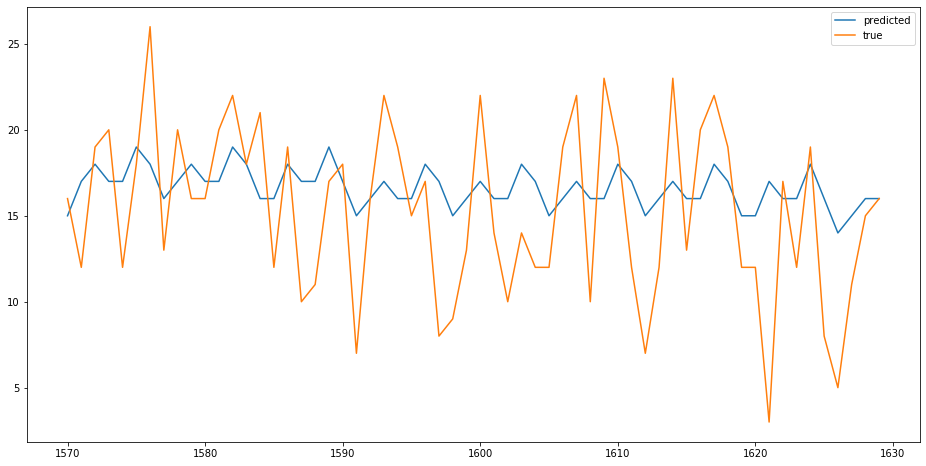

In [20]:
df_pred.plot(figsize=(16,8))

In [21]:
sc.stop()

In [ ]:
#xmin = -87.8062
#xmax = -87.7052
#ymin = 41.8648
#ymax = 41.9105

### Crashes in Chicago

In [4]:
df = sqlContext.read.csv("/datasets/traffic_crashes.csv", header='true')

In [6]:
dfDay = (df
       .withColumn('Days', F.to_date("CRASH_DATE", 'MM/dd/yyyy hh:mm:ss a'))
      )

In [7]:
pd_df = dfDay.groupBy("Days").count().toPandas().sort_values(by = "Days").reset_index(drop=True)

In [8]:
pd_df["Days"] = pd.DatetimeIndex(pd_df["Days"])
pd_df = pd_df.rename(columns={'Days': 'ds', 'count': 'y'})

In [9]:
m = Prophet(mcmc_samples=300)
m.fit(pd_df[:-60])
future = m.make_future_dataframe(
    periods=60,
    freq='d',
    include_history=True
)
fcst = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ubuntu/anaconda3/envs/dat500/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [10]:
forecasted_data = {'predicted': fcst.yhat[-60:].apply(lambda x: int(x)), 'true': pd_df.y[-60:]}
df_pred = pd.DataFrame(data=forecasted_data)
df_pred.head(15)

,predicted,true
1621,323,346
1622,333,303
1623,330,324
1624,332,356
1625,360,355
1626,335,310
1627,293,265
1628,325,324
1629,333,376
1630,329,323


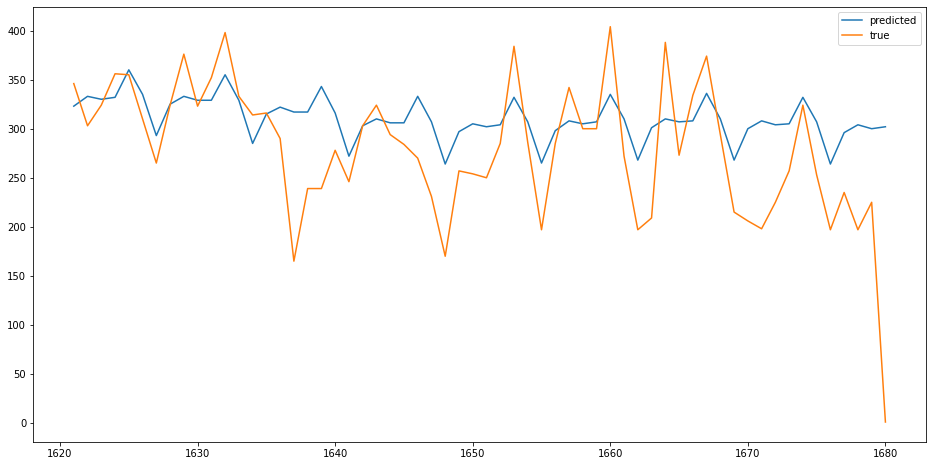

In [11]:
df_pred.plot(figsize=(10,8))